## Dataset Used: intermediate.jsoncel from ocpa github sample logs

In [1]:
#make a readme and a requirements file

# Importing Event Log 


In [2]:
from ocpa.objects.log.importer.ocel import factory as ocel_import_factory
filename = "intermediate.jsonocel"
ocel = ocel_import_factory.apply(filename)

# the filetype of the datasets posted on the ocel website does not match the ocpm documentation input filetype
# json vs jsonocel

# Process Discovery


In [3]:
from ocpa.algo.discovery.ocpn import algorithm as ocpn_discovery_factory
from ocpa.visualization.oc_petri_net import factory as ocpn_vis_factory
ocel = ocel_import_factory.apply(file_path=filename)
ocpn = ocpn_discovery_factory.apply(ocel, parameters={"debug": False})
ocpn_vis_factory.save(ocpn_vis_factory.apply(ocpn), "oc_petri_net.png")

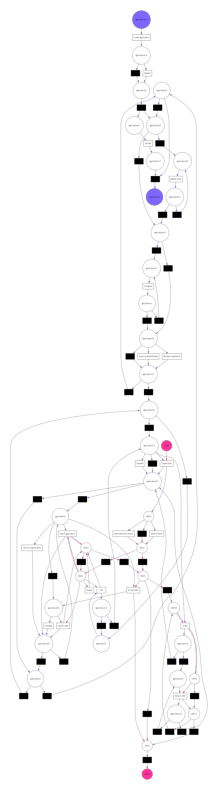

In [4]:
#view the ocpm petri net
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# cannot increase the size of image here, tried out matplotlib and graphviz paramtere tuning
img = mpimg.imread("oc_petri_net.png")
plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.axis("off")  # Hide axes
plt.show()

In [5]:
#variant calculation and layouting
#The variant layouting just returns a positioning of chevrons as coordinates.
#Instead of drawing the entire process flow directly, the layout algorithm only computes coordinates (X, Y positions) for these elements, 
#so they can be plotted or displayed.


from ocpa.visualization.log.variants import factory as variants_visualization_factory
print("Number of process executions: "+str(len(ocel.process_executions)))
print("Number of variants: "+str(len(ocel.variants)))
variant_layouting = variants_visualization_factory.apply(ocel)
print(variant_layouting[ocel.variants[0]])

Number of process executions: 1000
Number of variants: 917
([['Accept offer', [[11, 11], [0, 1]]], ['Pending', [[12, 12], [0]]], ['Cancel offer', [[13, 13], [0, 2]]], ['Cancel offer', [[14, 14], [0, 3]]], ['Cancel offer', [[15, 15], [0, 4]]], ['Create offer', [[6, 6], [0, 2]]], ['Create offer', [[7, 7], [0, 1]]], ['Send (mail and online)', [[8, 8], [1]]], ['Send (mail and online)', [[7, 12], [2]]], ['Create application', [[0, 0], [0]]], ['Accept', [[1, 1], [0]]], ['Create offer', [[2, 2], [0, 4]]], ['Send (mail and online)', [[3, 3], [4]]], ['Complete', [[3, 3], [0]]], ['Call', [[4, 4], [0, 4]]], ['Create offer', [[5, 5], [0, 3]]], ['Send (mail and online)', [[6, 13], [3]]], ['Validate', [[8, 8], [0]]], ['Return', [[9, 10], [1]]], ['Call incomplete files', [[9, 9], [0]]], ['Validate', [[10, 10], [0]]]], {0: ('application', 'application_1'), 1: ('offer', 'offer_1'), 2: ('offer', 'offer_2'), 3: ('offer', 'offer_3'), 4: ('offer', 'offer_4')})


Hard to display 917 variants, checked on the variant explorer in ocpi
Only 2 objects , application and offer , only seen application 1 but multiple offers (offer1, offer 2... 5)

# Precision and Fitness

In [ ]:
from ocpa.algo.conformance.precision_and_fitness import evaluator as quality_measure_factory

precision, fitness = quality_measure_factory.apply(ocel, ocpn)
print("Precision of IM-discovered net: "+str(precision))
print("Fitness of IM-discovered net: "+str(fitness))
#too long compilation, going over an hour and still no output (maybe cause of the flattening>metrics>combining)

Filtering variants as precision and fitness gets stuck in a never ending compile loop

In [ ]:
from ocpa.algo.discovery.ocel.variants import algorithm as variants_discovery

variants = variants_discovery.apply(ocel)
print(f"Total Variants: {len(variants)}")


In [ ]:
selected_variants = {k: v for k, v in variants.items() if len(v) > 10}  # Keep only frequent variants
filtered_ocel = ocel.filter_events(lambda e: e["case_id"] in selected_variants)


In [ ]:
precision, fitness = quality_measure_factory.apply(filtered_ocel, ocpn)
print("Precision:", precision)
print("Fitness:", fitness)

# Constraint Monitoring

In [ ]:
from ocpa.algo.enhancement.token_replay_based_performance import algorithm as performance_factory
from ocpa.objects.graph.constraint_graph.obj import ConstraintGraph, ActivityNode, ObjectTypeNode, FormulaNode, ControlFlowEdge, ObjectRelationEdge, PerformanceEdge
import ocpa.algo.conformance.constraint_monitoring.algorithm as constraint_monitoring_factory

diag_params = {'measures': ['act_freq', 'arc_freq', 'object_count', 'waiting_time', 'service_time', 'sojourn_time', 'synchronization_time', 'pooling_time', 'lagging_time', 'flow_time'], 'agg': [
    'mean', 'min', 'max']}
diag = performance_factory.apply(ocpn, ocel, parameters=diag_params)

# Example1: VM and PGI should not be concurrently executed.
cg1 = ConstraintGraph('Example1')
act_vm = ActivityNode('Verify Material')
act_pgi = ActivityNode('Plan Goods Issue')
cg1.add_nodes([act_vm, act_pgi])
cf1 = ControlFlowEdge(act_vm, act_pgi, 'concur', 'MATERIAL', 0.1)
cg1.add_cf_edge(cf1)
violated, diagnostics = constraint_monitoring_factory.apply(
    cg1, ocel, diag, parameters=None)
if violated:
    print(diagnostics)

# Example2: CPR should alway be followed by CPO.
cg2 = ConstraintGraph('Example2')
act_cpr = ActivityNode('Create Purchase Requisition (CPR)')
act_cpo = ActivityNode('Create Purchase Order (CPO)')
cg2.add_nodes([act_cpr, act_cpo])
cf2 = ControlFlowEdge(act_cpr, act_cpo, 'causal', 'PURCHREQ', 0.99)
cg2.add_cf_edge(cf2)
violated, diagnostics = constraint_monitoring_factory.apply(
    cg2, ocel, diag, parameters=None)
if violated:
    print(diagnostics)

# Example3: CPR should not be skipped
cg3 = ConstraintGraph('Example3')
act_cpr = ActivityNode('Create Purchase Requisition (CPR)')
cg3.add_nodes([act_cpr])
cf3 = ControlFlowEdge(act_cpr, act_cpr, 'skip', 'PURCHREQ', 0)
cg3.add_cf_edge(cf3)
violated, diagnostics = constraint_monitoring_factory.apply(
    cg3, ocel, diag, parameters=None)
if violated:
    print(diagnostics)

# Example4: PGI should always involve PURCHORD
cg4 = ConstraintGraph('Example4')
act_pgi = ActivityNode('Plan Goods Issue')
obj_node1 = ObjectTypeNode('PURCHORD')
cg4.add_nodes([act_pgi, obj_node1])
or1 = ObjectRelationEdge(obj_node1, act_pgi, 'absent', 0)
cg4.add_obj_edge(or1)
violated, diagnostics = constraint_monitoring_factory.apply(
    cg4, ocel, diag, parameters=None)
if violated:
    print(diagnostics)

# Example5: PGI should not involve MATERIAL
cg5 = ConstraintGraph('Example5')
act_pgi = ActivityNode('Plan Goods Issue')
obj_node2 = ObjectTypeNode('MATERIAL')
cg5.add_nodes([act_cpr])
or2 = ObjectRelationEdge(obj_node2, act_pgi, 'present', 0)
cg5.add_obj_edge(or2)
violated, diagnostics = constraint_monitoring_factory.apply(
    cg5, ocel, diag, parameters=None)
if violated:
    print(diagnostics)

# Example6: CPO should involve only one PURCHORD
cg6 = ConstraintGraph('Example6')
act_cpo = ActivityNode('Create Purchase Order (CPO)')
obj_node1 = ObjectTypeNode('PURCHORD')
cg6.add_nodes([obj_node1, act_cpo])
or3 = ObjectRelationEdge(obj_node1, act_cpo, 'singular', 0.99)
cg6.add_obj_edge(or3)
violated, diagnostics = constraint_monitoring_factory.apply(
    cg6, ocel, diag, parameters=None)
if violated:
    print(diagnostics)

# Example7: CPO should mostly involve multiple PURCHORD
cg7 = ConstraintGraph('Example7')
act_cpo = ActivityNode('Plan Goods Issue')
obj_node2 = ObjectTypeNode('MATERIAL')
cg7.add_nodes([act_cpo, obj_node2])
or4 = ObjectRelationEdge(obj_node2, act_cpo, 'multiple', 0.7)
cg7.add_obj_edge(or4)
violated, diagnostics = constraint_monitoring_factory.apply(
    cg7, ocel, diag, parameters=None)
if violated:
    print(diagnostics)

In [ ]:
this is the ocpm code used for constrain monitoring for an example log, i want you to create constraint monitoring for intermidiate log which i will provide along:
from ocpa.objects.log.importer.ocel import factory as ocel_import_factory
from ocpa.algo.discovery.ocpn import algorithm as ocpn_discovery_factory
from ocpa.algo.enhancement.token_replay_based_performance import algorithm as performance_factory
from ocpa.objects.graph.constraint_graph.obj import ConstraintGraph, ActivityNode, ObjectTypeNode, FormulaNode, ControlFlowEdge, ObjectRelationEdge, PerformanceEdge
import ocpa.algo.conformance.constraint_monitoring.algorithm as constraint_monitoring_factory

filename = "<path-to-your-log>"
ocel = ocel_import_factory.apply(filename)
ocpn = ocpn_discovery_factory.apply(ocel)
diag_params = {'measures': ['act_freq', 'arc_freq', 'object_count', 'waiting_time', 'service_time', 'sojourn_time', 'synchronization_time', 'pooling_time', 'lagging_time', 'flow_time'], 'agg': [
    'mean', 'min', 'max']}
diag = performance_factory.apply(ocpn, ocel, parameters=diag_params)

# Example1: VM and PGI should not be concurrently executed.
cg1 = ConstraintGraph('Example1')
act_vm = ActivityNode('Verify Material')
act_pgi = ActivityNode('Plan Goods Issue')
cg1.add_nodes([act_vm, act_pgi])
cf1 = ControlFlowEdge(act_vm, act_pgi, 'concur', 'MATERIAL', 0.1)
cg1.add_cf_edge(cf1)
violated, diagnostics = constraint_monitoring_factory.apply(
    cg1, ocel, diag, parameters=None)
if violated:
    print(diagnostics)

# Example2: CPR should alway be followed by CPO.
cg2 = ConstraintGraph('Example2')
act_cpr = ActivityNode('Create Purchase Requisition (CPR)')
act_cpo = ActivityNode('Create Purchase Order (CPO)')
cg2.add_nodes([act_cpr, act_cpo])
cf2 = ControlFlowEdge(act_cpr, act_cpo, 'causal', 'PURCHREQ', 0.99)
cg2.add_cf_edge(cf2)
violated, diagnostics = constraint_monitoring_factory.apply(
    cg2, ocel, diag, parameters=None)
if violated:
    print(diagnostics)

# Example3: CPR should not be skipped
cg3 = ConstraintGraph('Example3')
act_cpr = ActivityNode('Create Purchase Requisition (CPR)')
cg3.add_nodes([act_cpr])
cf3 = ControlFlowEdge(act_cpr, act_cpr, 'skip', 'PURCHREQ', 0)
cg3.add_cf_edge(cf3)
violated, diagnostics = constraint_monitoring_factory.apply(
    cg3, ocel, diag, parameters=None)
if violated:
    print(diagnostics)

# Example4: PGI should always involve PURCHORD
cg4 = ConstraintGraph('Example4')
act_pgi = ActivityNode('Plan Goods Issue')
obj_node1 = ObjectTypeNode('PURCHORD')
cg4.add_nodes([act_pgi, obj_node1])
or1 = ObjectRelationEdge(obj_node1, act_pgi, 'absent', 0)
cg4.add_obj_edge(or1)
violated, diagnostics = constraint_monitoring_factory.apply(
    cg4, ocel, diag, parameters=None)
if violated:
    print(diagnostics)

# Example5: PGI should not involve MATERIAL
cg5 = ConstraintGraph('Example5')
act_pgi = ActivityNode('Plan Goods Issue')
obj_node2 = ObjectTypeNode('MATERIAL')
cg5.add_nodes([act_cpr])
or2 = ObjectRelationEdge(obj_node2, act_pgi, 'present', 0)
cg5.add_obj_edge(or2)
violated, diagnostics = constraint_monitoring_factory.apply(
    cg5, ocel, diag, parameters=None)
if violated:
    print(diagnostics)

# Example6: CPO should involve only one PURCHORD
cg6 = ConstraintGraph('Example6')
act_cpo = ActivityNode('Create Purchase Order (CPO)')
obj_node1 = ObjectTypeNode('PURCHORD')
cg6.add_nodes([obj_node1, act_cpo])
or3 = ObjectRelationEdge(obj_node1, act_cpo, 'singular', 0.99)
cg6.add_obj_edge(or3)
violated, diagnostics = constraint_monitoring_factory.apply(
    cg6, ocel, diag, parameters=None)
if violated:
    print(diagnostics)

# Example7: CPO should mostly involve multiple PURCHORD
cg7 = ConstraintGraph('Example7')
act_cpo = ActivityNode('Plan Goods Issue')
obj_node2 = ObjectTypeNode('MATERIAL')
cg7.add_nodes([act_cpo, obj_node2])
or4 = ObjectRelationEdge(obj_node2, act_cpo, 'multiple', 0.7)
cg7.add_obj_edge(or4)
violated, diagnostics = constraint_monitoring_factory.apply(
    cg7, ocel, diag, parameters=None)
if violated:
    print(diagnostics)



# Process Analysis

In [ ]:
filename = "./sample_logs/jsonocel/p2p-normal.jsonocel"
ocel = ocel_import_factory.apply(filename)
ocpn = ocpn_discovery_factory.apply(ocel)
diag_params = {'measures': ['act_freq', 'arc_freq', 'object_count', 'waiting_time', 'service_time', 'sojourn_time', 'synchronization_time', 'pooling_time', 'lagging_time', 'flow_time'], 'agg': [
    'mean', 'min', 'max'], 'format': 'svg'}
diag = performance_factory.apply(ocpn, ocel, parameters=diag_params)
print(f'Diagnostics: {diag}')
gviz = ocpn_vis_factory.apply(
    ocpn, diagnostics=diag, variant="annotated_with_opera", parameters=diag_params)
ocpn_vis_factory.view(gviz)

# Predictive Monitoring